In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [12]:
TRAIN_PATH_CANDIDATES = ["mnist_train.csv", "/Users/andresojeda/Desktop/Artificial-Intelligence-Class/HMW3/mnt/data/mnist_train.csv"]
TEST_PATH_CANDIDATES  = ["mnist_test.csv",  "/Users/andresojeda/Desktop/Artificial-Intelligence-Class/HMW3/mnt/data/mnist_test.csv"]

NORMALIZE_TO_01 = True
VAR_EPS = 1e-2
SUBSAMPLE = False
TRAIN_LIMIT = 20000
TEST_LIMIT  = 5000

In [13]:
def find_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

In [14]:
def load_mnist_csv(train_paths, test_paths, normalize=True, subsample=False, train_limit=20000, test_limit=5000):
    train_path = find_first_existing(train_paths)
    test_path  = find_first_existing(test_paths)
    if train_path is None or test_path is None:
        raise FileNotFoundError(
            "Could not find 'mnist_train.csv' and/or 'mnist_test.csv'. "
            "Place them next to the notebook or in /mnt/data."
        )
    # Load
    t0 = time()
    train_df = pd.read_csv(train_path, header=None)
    test_df  = pd.read_csv(test_path, header=None)
    print(f"Loaded train shape={train_df.shape}, test shape={test_df.shape} in {time()-t0:.2f}s")

    if subsample:
        train_df = train_df.iloc[:train_limit].copy()
        test_df  = test_df.iloc[:test_limit].copy()

    # Split labels and features
    y_train = train_df.iloc[:, 0].astype(int).values
    X_train = train_df.iloc[:, 1:].astype(np.float32).values
    y_test  = test_df.iloc[:, 0].astype(int).values
    X_test  = test_df.iloc[:, 1:].astype(np.float32).values

    # Normalization
    if normalize:
        X_train = X_train / 255.0
        X_test  = X_test  / 255.0

    return X_train, y_train, X_test, y_test

In [15]:
def show_examples(X, y, count=6):
    fig, axes = plt.subplots(1, count, figsize=(count*2, 2))
    idxs = np.linspace(0, len(y)-1, count, dtype=int)
    for ax, i in zip(axes, idxs):
        ax.imshow(X[i].reshape(28,28), cmap="gray")
        ax.set_title(f"y={y[i]}")
        ax.axis("off")
    plt.show()

In [16]:
def compute_priors(y, n_classes=10):
    counts = np.bincount(y, minlength=n_classes).astype(np.float64)
    priors = counts / counts.sum()
    return priors, counts

def fit_gaussian_nb(X, y, n_classes=10, var_eps=1e-2):
    n_features = X.shape[1]
    means  = np.zeros((n_classes, n_features), dtype=np.float64)
    vars_  = np.zeros((n_classes, n_features), dtype=np.float64)

    priors, counts = compute_priors(y, n_classes=n_classes)

    for c in range(n_classes):
        Xc = X[y == c]
        if len(Xc) == 0:
            means[c] = 0.0
            vars_[c] = 1.0
            continue
        means[c] = Xc.mean(axis=0, dtype=np.float64)
        v = Xc.var(axis=0, dtype=np.float64)
        vars_[c] = v + var_eps

    return means, vars_, priors, counts

In [17]:
def log_gaussian_pdf(X, mean, var):
    # Ensure shapes broadcast: X - mean -> (n_samples, n_features)
    term1 = -0.5 * np.sum(np.log(2.0 * np.pi * var), axis=-1)  # scalar for the class
    term2 = -0.5 * np.sum(((X - mean) ** 2) / var, axis=-1)    # (n_samples,)
    return term1 + term2

def predict_log_proba(X, means, vars_, priors):
    n_samples = X.shape[0]
    n_classes = means.shape[0]
    log_proba = np.empty((n_samples, n_classes), dtype=np.float64)

    log_priors = np.log(priors + 1e-12)  # safe log
    for c in range(n_classes):
        log_lik = log_gaussian_pdf(X, means[c], vars_[c])  # (n_samples,)
        log_proba[:, c] = log_priors[c] + log_lik
    return log_proba


In [18]:
def predict(X, means, vars_, priors):
    log_proba = predict_log_proba(X, means, vars_, priors)
    return np.argmax(log_proba, axis=1)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def confusion_matrix(y_true, y_pred, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

In [19]:
def per_class_accuracy(cm):
    # diagonal / row sum
    with np.errstate(divide='ignore', invalid='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        pc = np.where(row_sums != 0, cm.diagonal().reshape(-1,1) / row_sums, 0.0).flatten()
    return pc

Loaded train shape=(60000, 785), test shape=(10000, 785) in 1.73s

Showing a few training examples...


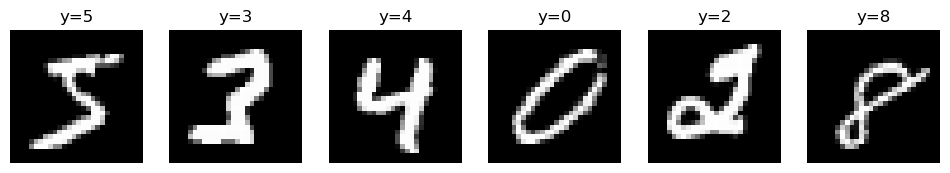

Fitting Gaussian Naive Bayes parameters...
Done in 0.25s
Evaluating on test set...
Overall test accuracy: 81.41% (computed in 0.22s)

Per-class accuracy:
  0: 92.14%
  1: 96.48%
  2: 75.58%
  3: 79.60%
  4: 64.97%
  5: 64.01%
  6: 90.71%
  7: 80.64%
  8: 76.80%
  9: 89.59%

Confusion Matrix (rows=true, cols=pred):


,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9
T0,903,0,1,4,1,8,21,1,37,4
T1,0,1095,1,6,0,0,6,0,27,0
T2,15,26,780,31,7,5,63,12,87,6
T3,4,33,28,804,2,19,16,11,49,44
T4,4,4,5,0,638,6,24,1,21,279
T5,20,24,7,94,20,571,23,10,75,48
T6,12,15,12,1,9,24,869,0,15,1
T7,0,32,8,5,21,1,3,829,25,104
T8,7,64,10,30,11,19,10,4,748,71
T9,6,13,3,8,37,2,0,13,23,904


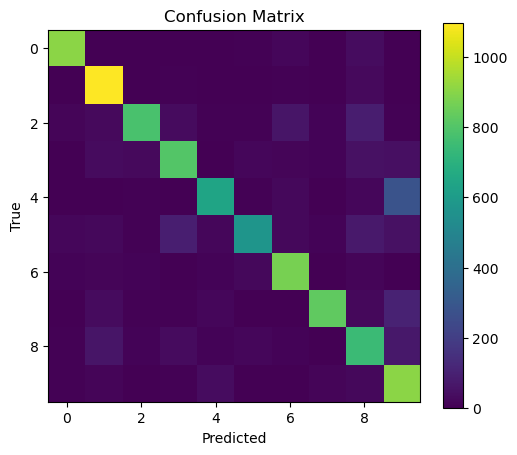

In [20]:
X_train, y_train, X_test, y_test = load_mnist_csv(
    TRAIN_PATH_CANDIDATES,
    TEST_PATH_CANDIDATES,
    normalize=NORMALIZE_TO_01,
    subsample=SUBSAMPLE,
    train_limit=TRAIN_LIMIT,
    test_limit=TEST_LIMIT
)

print("\nShowing a few training examples...")
show_examples(X_train, y_train, count=6)

print("Fitting Gaussian Naive Bayes parameters...")
t0 = time()
means, vars_, priors, counts = fit_gaussian_nb(X_train, y_train, n_classes=10, var_eps=VAR_EPS)
print(f"Done in {time()-t0:.2f}s")

print("Evaluating on test set...")
t1 = time()
y_pred = predict(X_test, means, vars_, priors)
elapsed = time() - t1
overall_acc = accuracy(y_test, y_pred)
print(f"Overall test accuracy: {overall_acc*100:.2f}% (computed in {elapsed:.2f}s)")

cm = confusion_matrix(y_test, y_pred, n_classes=10)
pc_acc = per_class_accuracy(cm)

# Pretty print per-class accuracy
print("\nPer-class accuracy:")
for digit, acc in enumerate(pc_acc):
    print(f"  {digit}: {acc*100:.2f}%")

# Tiny confusion-matrix preview (top-left 10x10)
print("\nConfusion Matrix (rows=true, cols=pred):")
df_cm = pd.DataFrame(cm, index=[f"T{d}" for d in range(10)], columns=[f"P{d}" for d in range(10)])
display(df_cm)

# If you also want a quick plot of the confusion matrix counts (optional)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


Accuracy Results: My Gaussian Naive Bayes classifier achieved an overall test accuracy of 81.41% on MNIST. Per-class accuracies ranged from ~64% (digits 4 and 5) up to ~96% (digit 1). This shows the model is strong for some digits (0, 1, 6) but struggles more with visually similar digits (4, 5, 7).